# bQTL distance to motif vs p-value
- Take the bQTL SNPs from supplemental material section of bQTL paper (mmc2.xlsx). There are four tabs in the xlsx, one for each TF (JUND/RELA/SPI1/STAT1). Each entry in the table contains the location and p-value for an SNP, among other info.
- For each TF, take first 100k bQTLs of smallest pvals (there are too many SNPs)
- Calculate the distance between each bQTL SNP to its nearest CIS-BP motif center. As the CIS-BP motifs do not come with weights, the motif center is simply (start+end)/2
- Cap the distance at 1000bp and 10,000bp and plot the distance vs -log10(p-value)

In [1]:
from __future__ import print_function, division

import sys
import os
#import matplotlib as mpl
#mpl.use('Agg')

import numpy as np
import sys
import argparse

In [2]:

MAX_LOC = 250000000L
def chrom_to_idx(chrom, loc):
    chrid = chrom[3:]
    if chrid == 'x' or chrid == 'X':
        chrnm = 23
    elif chrid == 'y' or chrid == 'Y':
        chrnm = 24
    else:
        chrnm = int(chrid)
    return long(chrnm * MAX_LOC + loc)

def idx_to_chrom(idx):
    loc = idx % MAX_LOC
    chrid = int(idx / MAX_LOC)
    if chrid == 23:
        chrom = 'chrX'
    elif chrid == 24:
        chrom = 'chrY'
    else:
        chrom = 'chr' + str(chrid)
    return chrom, loc
        
    
def calc_seq_loc(seq):
    st = seq.coor.start
    en = seq.coor.end
    local = int((st + en)/2) # fix later using center of gravity

    tsv = merged_tsv_list[seq.coor.example_idx]
    location = int(tsv[1]) + local
    if location > MAX_LOC:
        print("location=%d, tsv_start=%d, ex=%d, st=%d, en=%d" %(location, int(tsv[1]), seq.coor.example_idx, seq.coor.start, seq.coor.end))
        print(tsv)
    idx = chrom_to_idx(tsv[0], location)

    return idx, tsv[0], location



In [3]:
from collections import OrderedDict
tf_list = [ 'JUND', 'RELA', 'SPI1', 'STAT1']

tf_dict = OrderedDict()

for tf in tf_list:
    #with open("data/" + tf + "_sort.txt") as in_fh:
    with open("under_1ksummit/" + tf + "_sort.txt") as in_fh:

        lines = [ map(int, line.split()) for line in in_fh ]
        tf_dict[tf] = list(zip(*lines)) # transpose
        print(tf + " done")
            

JUND done
RELA done
SPI1 done
STAT1 done


In [4]:

from bisect import bisect_left
max_chrid = 25
bounds  = [0] * (max_chrid+1)


def find_nearest(my_list, my_idx):
    """
    Assumes my_list is sorted. Returns closest value to my_idx.
    If two numbers are equally close, return the smallest number.
    If lo
    """

    chrid = long(my_idx / MAX_LOC)
    lo = bounds[chrid-1]
    hi = bounds[chrid]
    if lo == hi:
        return -1, -1 # this chrom is empty
    
    # lo != hi, so the chrom is not empty
    pos = bisect_left(my_list, my_idx, lo=lo, hi=hi)

    if pos == lo:
        return lo, my_list[lo]
    if pos == hi:
        return hi-1, my_list[hi-1] # hi belongs to next chrom
    before = my_list[pos - 1]
    after = my_list[pos]
    #print(lo, hi, pos, before, after)
    if after - my_idx < my_idx - before:
       return pos, after
    else:
       return pos-1, before

Of top 100k JUND SNPs with highest p-val,  1544  SNPs' distances to the nearest motif center are < 1000


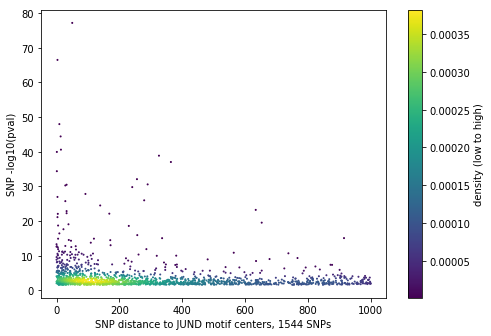

Of top 100k JUND SNPs with highest p-val,  90622  SNPs have motif in the same Chromosome


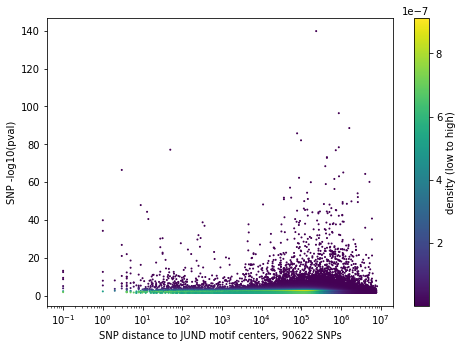

Of top 100k RELA SNPs with highest p-val,  3992  SNPs' distances to the nearest motif center are < 1000


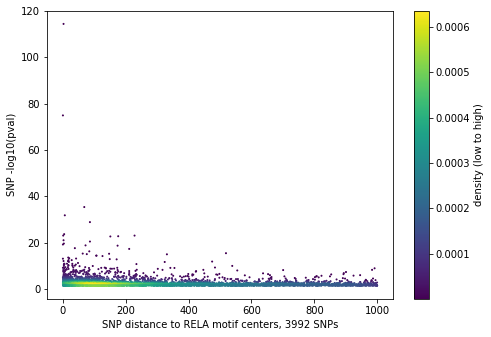

Of top 100k RELA SNPs with highest p-val,  90616  SNPs have motif in the same Chromosome


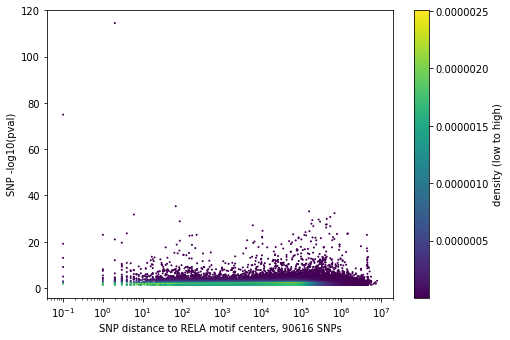

Of top 100k SPI1 SNPs with highest p-val,  4144  SNPs' distances to the nearest motif center are < 1000


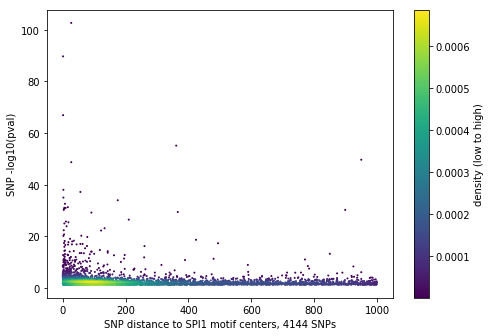

Of top 100k SPI1 SNPs with highest p-val,  90561  SNPs have motif in the same Chromosome


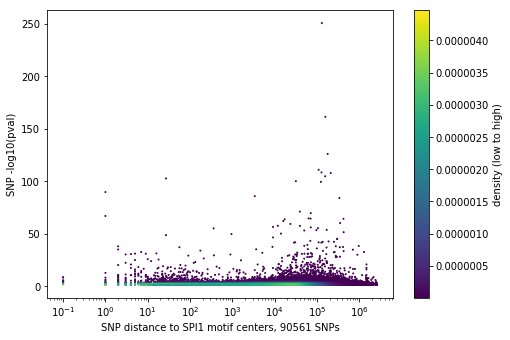

Of top 100k STAT1 SNPs with highest p-val,  2016  SNPs' distances to the nearest motif center are < 1000


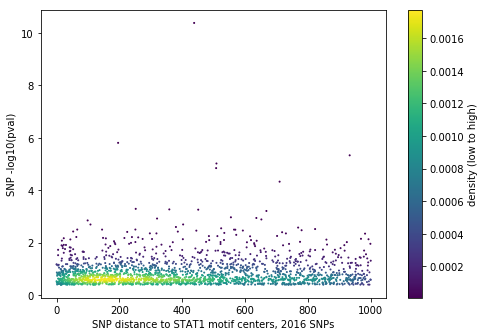

Of top 100k STAT1 SNPs with highest p-val,  89895  SNPs have motif in the same Chromosome


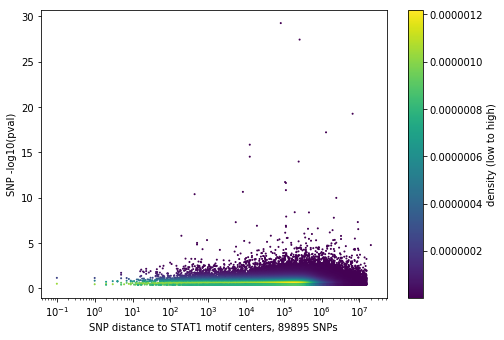

In [5]:
import math

for tf in tf_list:

    idx_array = tf_dict[tf][1]
    for chrid in range(1, max_chrid+1):
        lo_val = chrid * MAX_LOC
        bounds[chrid-1] = bisect_left(idx_array, lo_val)
        #print(chrid-1, lo_val, bounds[chrid-1])

    #print(idx_array[:10])
    #print(bounds)


    #snp_dir = "/Users/kat/kundajelab/tmp/bQTL/bQTL_all_SNPs/"
    snp_dir = "/home/ktian/kundajelab/tfnet/results/nandi/bQTL/analysis/bQTL_all_SNPs/"
    snp_list = []
    snp_file = tf + '_100k.txt'
    #snp_file = tf + '.txt'

    with open(snp_dir + snp_file) as in_fh:
        header = next(in_fh)
        line_num = 0
        for line in in_fh:
            fields = line.split('\t')
            snp_chrom = fields[0]
            snp_pos   = int(fields[1])
            pval  = float(fields[9])
            idx   = chrom_to_idx(snp_chrom, snp_pos)
            motif_off, motif_idx = find_nearest(idx_array, idx)
            if motif_off >= 0:
                snp_list.append([abs(idx-motif_idx), -math.log(pval,10)])
                #snp_list.append([abs(idx-motif_idx), pval])
            line_num += 1
    #print(snp_list[:5])     
    #print(len(snp_list))

    with open("under_1ksummit/" + tf + "_cisbp_big.tsv", "w") as fh:
        for row in snp_list:
            fh.write(str(row[0]) +"\t"+ str(row[1]) + "\n")

    %matplotlib inline

    import matplotlib.pyplot as plt
    import numpy as np
    import matplotlib
    from scipy.stats import gaussian_kde

    #fig=plt.figure(figsize=(10, 8), dpi= 100)
    snp_dist = [item[0] for item in snp_list if item[1] > 0 and item[0] <= 1000]
    snp_pval = [item[1] for item in snp_list if item[1] > 0 and item[0] <= 1000]

    x=snp_dist
    y=snp_pval
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    print("Of top 100k "+tf+" SNPs with highest p-val, ", len(snp_dist), " SNPs' distances to the nearest motif center are < 1000")
    fig = plt.figure()
    ax = fig.add_axes([1,1,1,1])
    plt.scatter(snp_dist, snp_pval, 1, c=z, alpha=1, marker='o', label=".")
    plt.xlabel("SNP distance to "+ tf +" motif centers, " + str(len(snp_dist)) + " SNPs")
    plt.ylabel("SNP -log10(pval)")
    plt.colorbar(label='density (low to high)')

    #plt.legend(loc=2)
    plt.show()    
    fig.savefig("under_1ksummit/" + tf + "_cisbp_1k_big.png", bbox_inches='tight')

    # https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib
    
    '''
    %matplotlib inline

    import matplotlib.pyplot as plt
    import numpy as np
    import matplotlib
    from scipy.stats import gaussian_kde

    #fig=plt.figure(figsize=(10, 8), dpi= 100)
    snp_dist = [item[0] for item in snp_list if item[1] > 0 and item[0] <= 10000]
    snp_pval = [item[1] for item in snp_list if item[1] > 0 and item[0] <= 10000]

    x=snp_dist
    y=snp_pval
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    print("Of top 100k "+tf+" SNPs with highest p-val, ", len(snp_dist), " SNPs' distances to the nearest motif center are < 10,000")
    plt.scatter(snp_dist, snp_pval, 1, c=z, alpha=1, marker='o', label=".")
    plt.xlabel("SNP distance to "+ tf +" motif centers (<10,000)")
    plt.ylabel("SNP -log10(pval)")
    plt.colorbar(label='density (low to high)')

    #plt.legend(loc=2)
    plt.show()    
    '''
    
    %matplotlib inline

    import matplotlib.pyplot as plt
    import numpy as np
    import matplotlib
    from scipy.stats import gaussian_kde

    for item in snp_list:
        if item[0] == 0:
            item[0] = 0.1
    #fig=plt.figure(figsize=(10, 8), dpi= 100)
    snp_dist = [item[0] for item in snp_list]
    snp_pval = [item[1] for item in snp_list]

    x=snp_dist
    y=snp_pval
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    print("Of top 100k "+tf+" SNPs with highest p-val, ", len(snp_dist), " SNPs have motif in the same Chromosome")
    fig = plt.figure()
    ax = fig.add_axes([1,1,1,1])
    plt.scatter(snp_dist, snp_pval, 1, c=z, alpha=1, marker='o', label=".")
    plt.xscale('log')
    #plt.yscale('log')
    plt.xlabel("SNP distance to "+ tf +" motif centers, " + str(len(snp_dist)) + " SNPs")
    plt.ylabel("SNP -log10(pval)")
    plt.colorbar(label='density (low to high)')

    #plt.legend(loc=2)
    plt.show()    
    fig.savefig("under_1ksummit/" + tf + "_cisbp_log_big.png", bbox_inches='tight')




In [6]:
!wc -l under_1ksummit/*sort.txt

  4361 under_1ksummit/JUND_sort.txt
  8917 under_1ksummit/RELA_sort.txt
 10747 under_1ksummit/SPI1_sort.txt
  1838 under_1ksummit/STAT1_sort.txt
 25863 total


above are the number of motifs for each TF in the CIS-BP database. The nearest motif center for a SNP is only calculated among motifs for the same TF. 